# Zillow House Price Prediction Analysis
### By: Xavier Carter


##### Project Scope 
-  Predicting the values of single unit properties that the tax district assesses using the property data from those with a transaction during the "hot months" of May-August, 2017.
    * To also include:
        - What state and county are located
        - The Tax rate distibution for each county
    

### Project Planning

    

- Create ReadMe.md with data dictionary, business goals, hypothesis and hypothesis testing results
- Aquire information from database 
- Prep and clean the data for more info for more visualizations, document findings
- Create deliverables for zillow that include the state and county for each property as well is the taxrate distributuons for each county
- Use visualizations to find possible MVP's, further my MVP testing with statstical analysis
- Create Hypothesis for each mvp,  alpha and find if rejecting the hypothesis is logical
- Create Baseline rmse score , document 
- Train classification models and evaluate results
- Choose best preforming model for test case , document findings
- Document conclusions / Take aways and next steps

## Aquire 

In [1]:
import pandas as pd
import numpy as np
import wrangle, prepare, Explore, evaluate
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')


This funtion pulls data from the Zillow database for **single unit properties** between the **Hot Months**
 - Single unit properties defined as Single Family Residential, Rural Residence and Townhouses
 - Hot months range between May and August

In [2]:
zillow_df = wrangle.get_zillow_data()

In [3]:
zillow_df.head()

,parcelid,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,taxamount,yearbuilt,regionidzip,fips,transactiondate
0,11721753,3.0,2.0,1316.0,205123.0,2627.48,1923.0,95997.0,6037.0,2017-07-21
1,11289917,3.0,2.0,1458.0,136104.0,2319.90,1970.0,97318.0,6037.0,2017-06-23
2,11705026,2.0,1.0,1421.0,35606.0,543.69,1911.0,96018.0,6037.0,2017-06-30
3,14269464,4.0,3.0,2541.0,880456.0,9819.72,2003.0,96958.0,6059.0,2017-06-01
4,11446756,3.0,2.0,1491.0,107110.0,1399.27,1955.0,96162.0,6037.0,2017-08-23


## Deliverables


- Here is a creation of a csv file containing property and the state, county, and tax rate of each property

In [4]:
deliverable_df = wrangle.zillow_engineering(zillow_df.copy())
deliverable_df = deliverable_df[['parcelid', 'State', 'County', 'taxrate' ]]
deliverable_df.to_csv('property_information.csv')

- Here is a creation of the tax rate distribution per county

<Figure size 648x360 with 0 Axes>

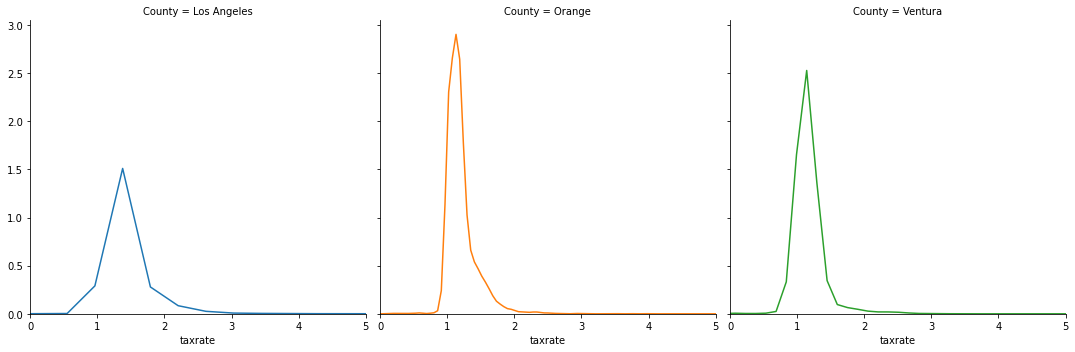

In [5]:
Explore.graph_distribution(deliverable_df, 'County', 'taxrate')

## Prepare
- Here I will continue the pipeline stage in order to prep for model building
     * Steps taken:
         - Gather summary statistics.
         - Check for nulls and remove or fill them.
         - Convert data types
         - Locate extreme outliers and remove them.

In [6]:
#looking back to original data prior to deliverable
zillow_df = zillow_df.drop(columns='taxamount')

In [7]:
wrangle.summerize_df(zillow_df)

-----shape------
28127 rows and 9 columns
---info---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28127 entries, 0 to 28126
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      28127 non-null  int64  
 1   bedroomcnt                    28127 non-null  float64
 2   bathroomcnt                   28127 non-null  float64
 3   calculatedfinishedsquarefeet  28080 non-null  float64
 4   taxvaluedollarcnt             28126 non-null  float64
 5   yearbuilt                     28056 non-null  float64
 6   regionidzip                   28110 non-null  float64
 7   fips                          28127 non-null  float64
 8   transactiondate               28127 non-null  object 
dtypes: float64(7), int64(1), object(1)
memory usage: 1.9+ MB
None
           parcelid    bedroomcnt   bathroomcnt  calculatedfinishedsquarefeet  \
count  2.812700e+04  28127.000000  28127.0

### Takeaways
- Handle nulls. remove and filled accordingly
- convert zipcode and fips to strings, as they are actually catagorical features
- Bin the transactiondate to months

In [8]:
#clean data using specifications above
zillow_df = wrangle.clean_zillow_data(zillow_df)

In [9]:
wrangle.summerize_df(zillow_df)

-----shape------
28065 rows and 9 columns
---info---
<class 'pandas.core.frame.DataFrame'>
Int64Index: 28065 entries, 0 to 28126
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      28065 non-null  int64  
 1   bedroomcnt                    28065 non-null  float64
 2   bathroomcnt                   28065 non-null  float64
 3   calculatedfinishedsquarefeet  28065 non-null  float64
 4   taxvaluedollarcnt             28065 non-null  float64
 5   yearbuilt                     28065 non-null  float64
 6   regionidzip                   28065 non-null  object 
 7   fips                          28065 non-null  float64
 8   transactionmonth              28065 non-null  int64  
dtypes: float64(6), int64(2), object(1)
memory usage: 2.1+ MB
None
           parcelid    bedroomcnt   bathroomcnt  calculatedfinishedsquarefeet  \
count  2.806500e+04  28065.000000  28065.0

## Outlier Handling, Splitting and Scaling Data
- removing extreme outliers as an attempt to normalize data more
- Here Splitting and scaling will be handled

In [10]:
zillow_df.shape

(28065, 9)

In [11]:
#outliers removed on a normal 25 lower /75 upper quartile range
#bedroom and bathroom count weighted differenty, more outliers on the upper end

for i in zillow_df.drop(columns=['parcelid','yearbuilt', 'fips','transactionmonth','regionidzip']):
    if i == 'bedroomcnt' or i =='bathroomcnt':
        zillow_df = wrangle.handle_outliers(zillow_df, i, .10, .65)
    else:
        zillow_df = wrangle.handle_outliers(zillow_df, i, .25, .75)

In [12]:
zillow_df.shape

(25170, 9)

In [13]:
'get dummies for fips' 
zillow_df = wrangle.get_dummies(zillow_df,['fips'])

In [14]:
train, validate, test = wrangle.split_for_model(zillow_df)

train(14095, 10),validate(6041, 10),test(5034, 10)


In [15]:
#min max scaling on continous variables, not including target                      
train_scaled, validate_scaled, test_scaled = prepare.scale_data(train, validate, test, scale_type='MinMax',
                                                                to_scale=['calculatedfinishedsquarefeet','yearbuilt'])

In [16]:
#continous variables specified scaled, everything else remains in its original unit of measure
train_scaled[:1]

,parcelid,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,regionidzip,transactionmonth,6059.0,6111.0
9566,11129103,4.0,3.0,0.589049,669514.0,0.717391,96356.0,6,0,0


## Exploration
- Visual exploration allows us to see possible trends visually before making MVP choices
    * Here We'll visualize possible correlations

In [17]:
#distributions
#Explore.get_distribution(train_scaled.drop(columns=['parcelid',6111.0,6059.0]))

### Takeaways
- normally distributed data for the most part

In [18]:
#Explore.plot_variable_pairs(train_scaled.drop(columns=['parcelid',6059.0, 6111.0,'regionidzip']), 2)

### Takeways
- the more expensive the unit, the more square footage it has
- AAll hot months were uniform in there distribution

In [19]:
cat_vars = ['bedroomcnt', 'bathroomcnt']
cont_vars = ['yearbuilt','taxvaluedollarcnt','calculatedfinishedsquarefeet']
#Explore.plot_cat_and_cont(cat_vars,cont_vars,train_scaled.sample(300))

In [20]:
#Explore.get_heatmap(train_scaled, 'taxvaluedollarcnt')

### Takeaways
- Possible Driver Selection
    * CalculatedFinishedSqrFeet
    * Bathroomcnt
    * yearbuilt

## Drivers
- we can see what kbest and rfe select as drivers

In [21]:
X_train = train_scaled.drop(columns=['parcelid','taxvaluedollarcnt'])
y_train = train_scaled.taxvaluedollarcnt

X_validate = validate_scaled.drop(columns=['parcelid','taxvaluedollarcnt'])
y_validate = validate_scaled.taxvaluedollarcnt

X_test = test_scaled.drop(columns=['parcelid','taxvaluedollarcnt'])
y_test = test_scaled.taxvaluedollarcnt

y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

In [22]:
kbest = evaluate.select_kbest(X_train, y_train.taxvaluedollarcnt, 4)
kbest

['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt']

In [23]:

rfe = evaluate.select_rfe(X_train, y_train.taxvaluedollarcnt, 4)
rfe

['bedroomcnt', 'calculatedfinishedsquarefeet', 6059.0, 6111.0]

## T-Test/ Pearsons

In [24]:
cat_vars = ['bathroomcnt', 'bedroomcnt']
evaluate.get_t_test(cat_vars,train_scaled,'taxvaluedollarcnt',0.05)


Null Hypothesis: bathroomcnt is not correlated to value 
Alternative hypothesis:  bathroomcnt is correlated to value 
p value 0.0 is less than alpha 0.05 , we reject our null hypothesis
-------------------------------------
Null Hypothesis: bedroomcnt is not correlated to value 
Alternative hypothesis:  bedroomcnt is correlated to value 
p value 0.0 is less than alpha 0.05 , we reject our null hypothesis
-------------------------------------


In [25]:
cont_vars = ['calculatedfinishedsquarefeet','yearbuilt']
evaluate.get_pearsons(cont_vars,'taxvaluedollarcnt', 0.05, train_scaled)

Null Hypothesis: calculatedfinishedsquarefeet is not correlated to value 
Alternative hypothesis:  calculatedfinishedsquarefeet is correlated to value 
p value 0.0 is less than alpha 0.05 , we reject our null hypothesis
-------------------------------------
Null Hypothesis: yearbuilt is not correlated to value 
Alternative hypothesis:  yearbuilt is correlated to value 
p value 2.8924909760528456e-201 is less than alpha 0.05 , we reject our null hypothesis
-------------------------------------


## Modeling

##### For modeling, since our target variable is skewed slightly to the left we will run through are linear regression models as well as a polynomial regression model

### Baseline

In [26]:
#RMSE of both mean and median
rmse_train_mean = evaluate.baseline_errors(train.taxvaluedollarcnt, measure = 'Mean')[2]
rmse_validate_mean = evaluate.baseline_errors(validate.taxvaluedollarcnt, measure = "Mean")[2]

rmse_train_median    = evaluate.baseline_errors(train.taxvaluedollarcnt, measure = 'Median')[2]
rmse_validate_median = evaluate.baseline_errors(validate.taxvaluedollarcnt, measure = 'Median')[2]

In [27]:
rmse_train_mean, rmse_train_median

(255638.59288387597, 258835.5032764235)

In [28]:
rmse_validate_mean, rmse_validate_median

(248733.2034945244, 251333.2197798989)

In [29]:
#mean baseline is harder to beat. we will use the mean moving forward
target = 'taxvaluedollarcnt'

### Linear Regression Model

In [30]:
evaluate.get_model_results(X_train[kbest], y_train,  X_train[kbest], 
                           y_train, target, 'linear')

RMSE Score: 223358.93605153105
r2 Score: 0.2365970608441998
Better than Basline: True


RMSE Score: 218841.9168761934
r2 Score: 0.25462472774836037
Better than Basline: True


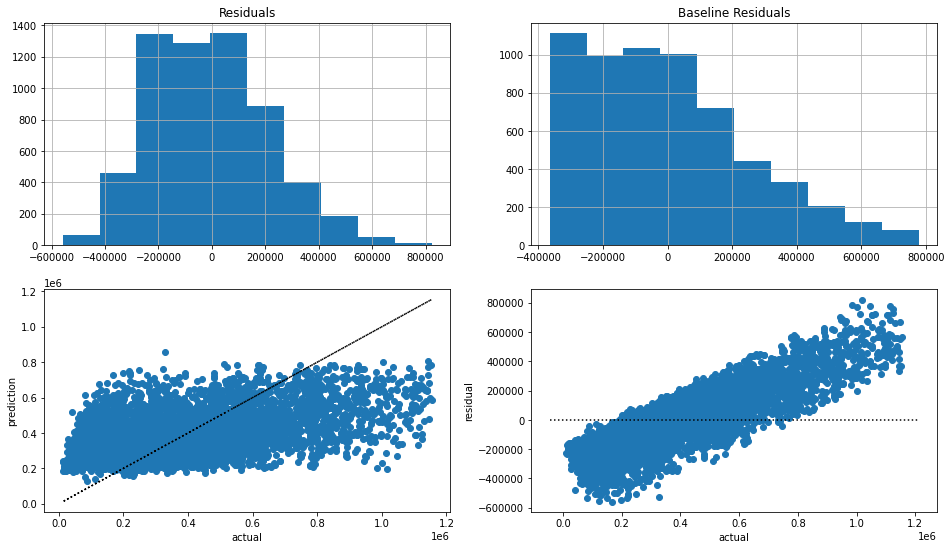

In [31]:
evaluate.get_model_results(X_train[kbest], y_train,  X_validate[kbest],
                           y_validate, target, 'linear', graph=True)

### Lasso-Lars Regression Model

In [32]:
evaluate.get_model_results(X_train[kbest], y_train, X_train[kbest], 
                           y_train, target, 'lasso',alpha=.05)

RMSE Score: 223358.93654906168
r2 Score: 0.23656405732801095
Better than Basline: True


RMSE Score: 218841.85070248018
r2 Score: 0.2545882920076813
Better than Basline: True


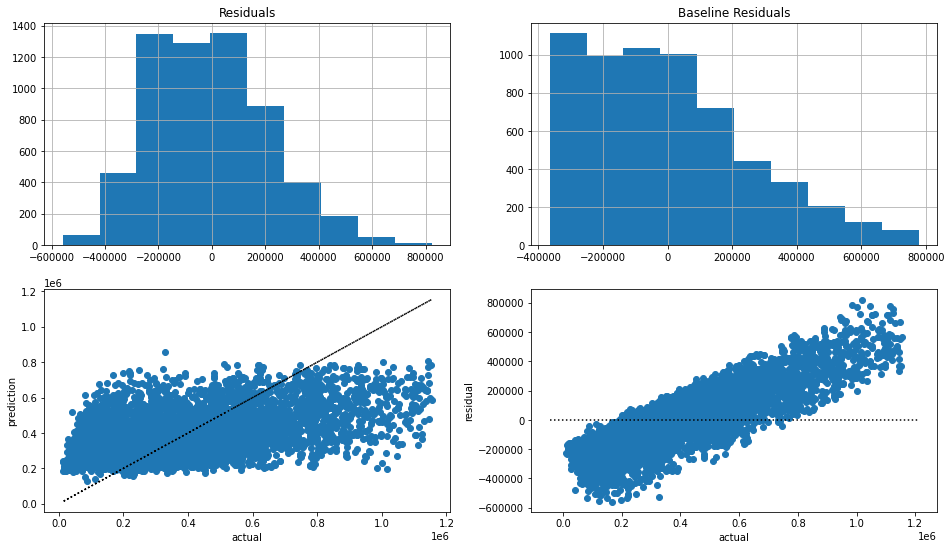

In [37]:
evaluate.get_model_results(X_train[kbest], y_train, X_validate[kbest], 
                           y_validate, target, 'lasso',alpha=.05, graph=True)

### Generalized Linear Model

In [51]:
evaluate.get_model_results(X_train[kbest], y_train, X_train[kbest], 
                           y_train, target, 'glm',alpha=4000, power=1)

RMSE Score: 225000.4749710957
r2 Score: 0.18799926159044666
Better than Basline: True


RMSE Score: 219221.4509838891
r2 Score: 0.2587408240375662
Better than Basline: True


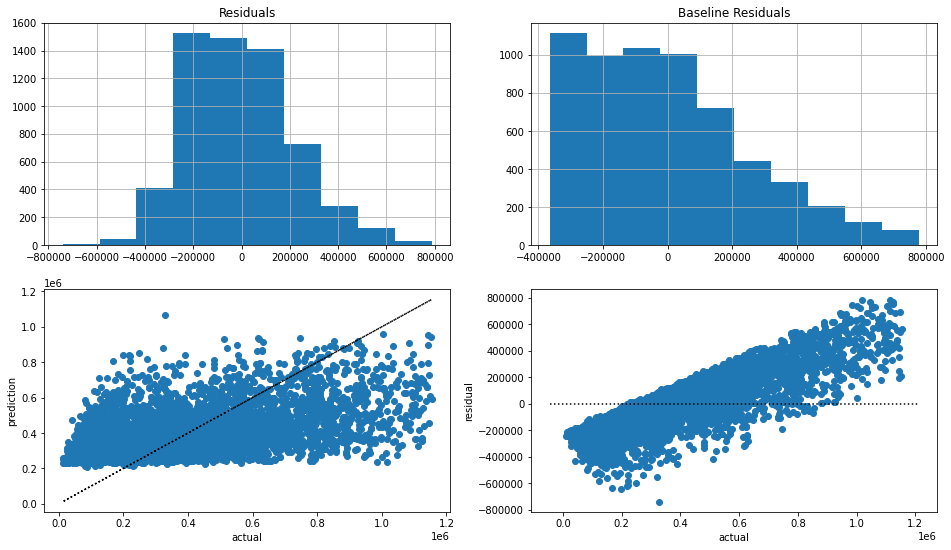

In [67]:
evaluate.get_model_results(X_train[kbest], y_train, X_validate[kbest], 
                           y_validate, target, 'glm',alpha=0, power=1, graph=True)